# Breast Cancer Imaging Analysis

HERE WE WILL IDENTIFY THE TYPE OF CALCIFICATION IN EACH IMAGE USING A FAST.AI ALGORITHM 

THERE ARE THREE CLASSES:
- Benign 
- Benign no callback
- Malignant

THE GOAL IS TO CLASSIFY IMAGES BY PATHOLOGY OBSERVED 

In [1]:
# packages to import

import pydicom as dicom
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import imageio

from fastai import *
from fastai.vision import * 
from torchvision.models import *


**THERE ARE TWO DATASETS. HERE WE ONLY USE THE CALCIFICATION DATASET**

The path is found in the ROI mask file path column

In [2]:
# loading the csv files into pandas dataframes

df_train_calc = pd.read_csv('calc_case_description_train_set.csv')
df_test_calc = pd.read_csv('calc_case_description_test_set.csv')

In [3]:
df_test_calc.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [4]:
df_test_calc.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [4]:
#File path for ROI images 
test_data_names = df_test_calc['ROI mask file path']
train_data_names = df_train_calc['ROI mask file path']

print('First 5 image paths for test data:', '\n','__________', '\n', test_data_names[:5])
print('_____________________')
print('First 5 image paths for train data:', '\n','__________', '\n', train_data_names[:5])

First 5 image paths for test data: 
 __________ 
 0    Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1    Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2    Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3    Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4    Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...
Name: ROI mask file path, dtype: object
_____________________
First 5 image paths for train data: 
 __________ 
 0    Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1    Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2    Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3    Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4    Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...
Name: ROI mask file path, dtype: object


**BEFORE CLASSIFICATION - HERE ARE THE CLASSIFICARTION NAMES**

In [5]:
# Test dataset
df_test_calc['pathology'].value_counts()

BENIGN                     130
MALIGNANT                  129
BENIGN_WITHOUT_CALLBACK     67
Name: pathology, dtype: int64

In [6]:
# Train dataset
df_train_calc['pathology'].value_counts()

MALIGNANT                  544
BENIGN                     528
BENIGN_WITHOUT_CALLBACK    474
Name: pathology, dtype: int64



**CREATE NUMPY ARRAYS OF THE IMAGES USING PYDICOM**

Save each array to the dataframe

In [7]:
def extract_img_arrays(file_paths, extension_path, dataframe):

    dataset = []
    data_arrays = []
    
    for link in file_paths:
        link = extension_path + link
        file = dicom.dcmread(link)
        dataset.append(file)
    
        data = file.pixel_array
        data_arrays.append(data)

    dataframe['image_arrays'] = data_arrays

extract_img_arrays(test_data_names, 'test images/', df_test_calc)
extract_img_arrays(train_data_names, 'train images/', df_train_calc)

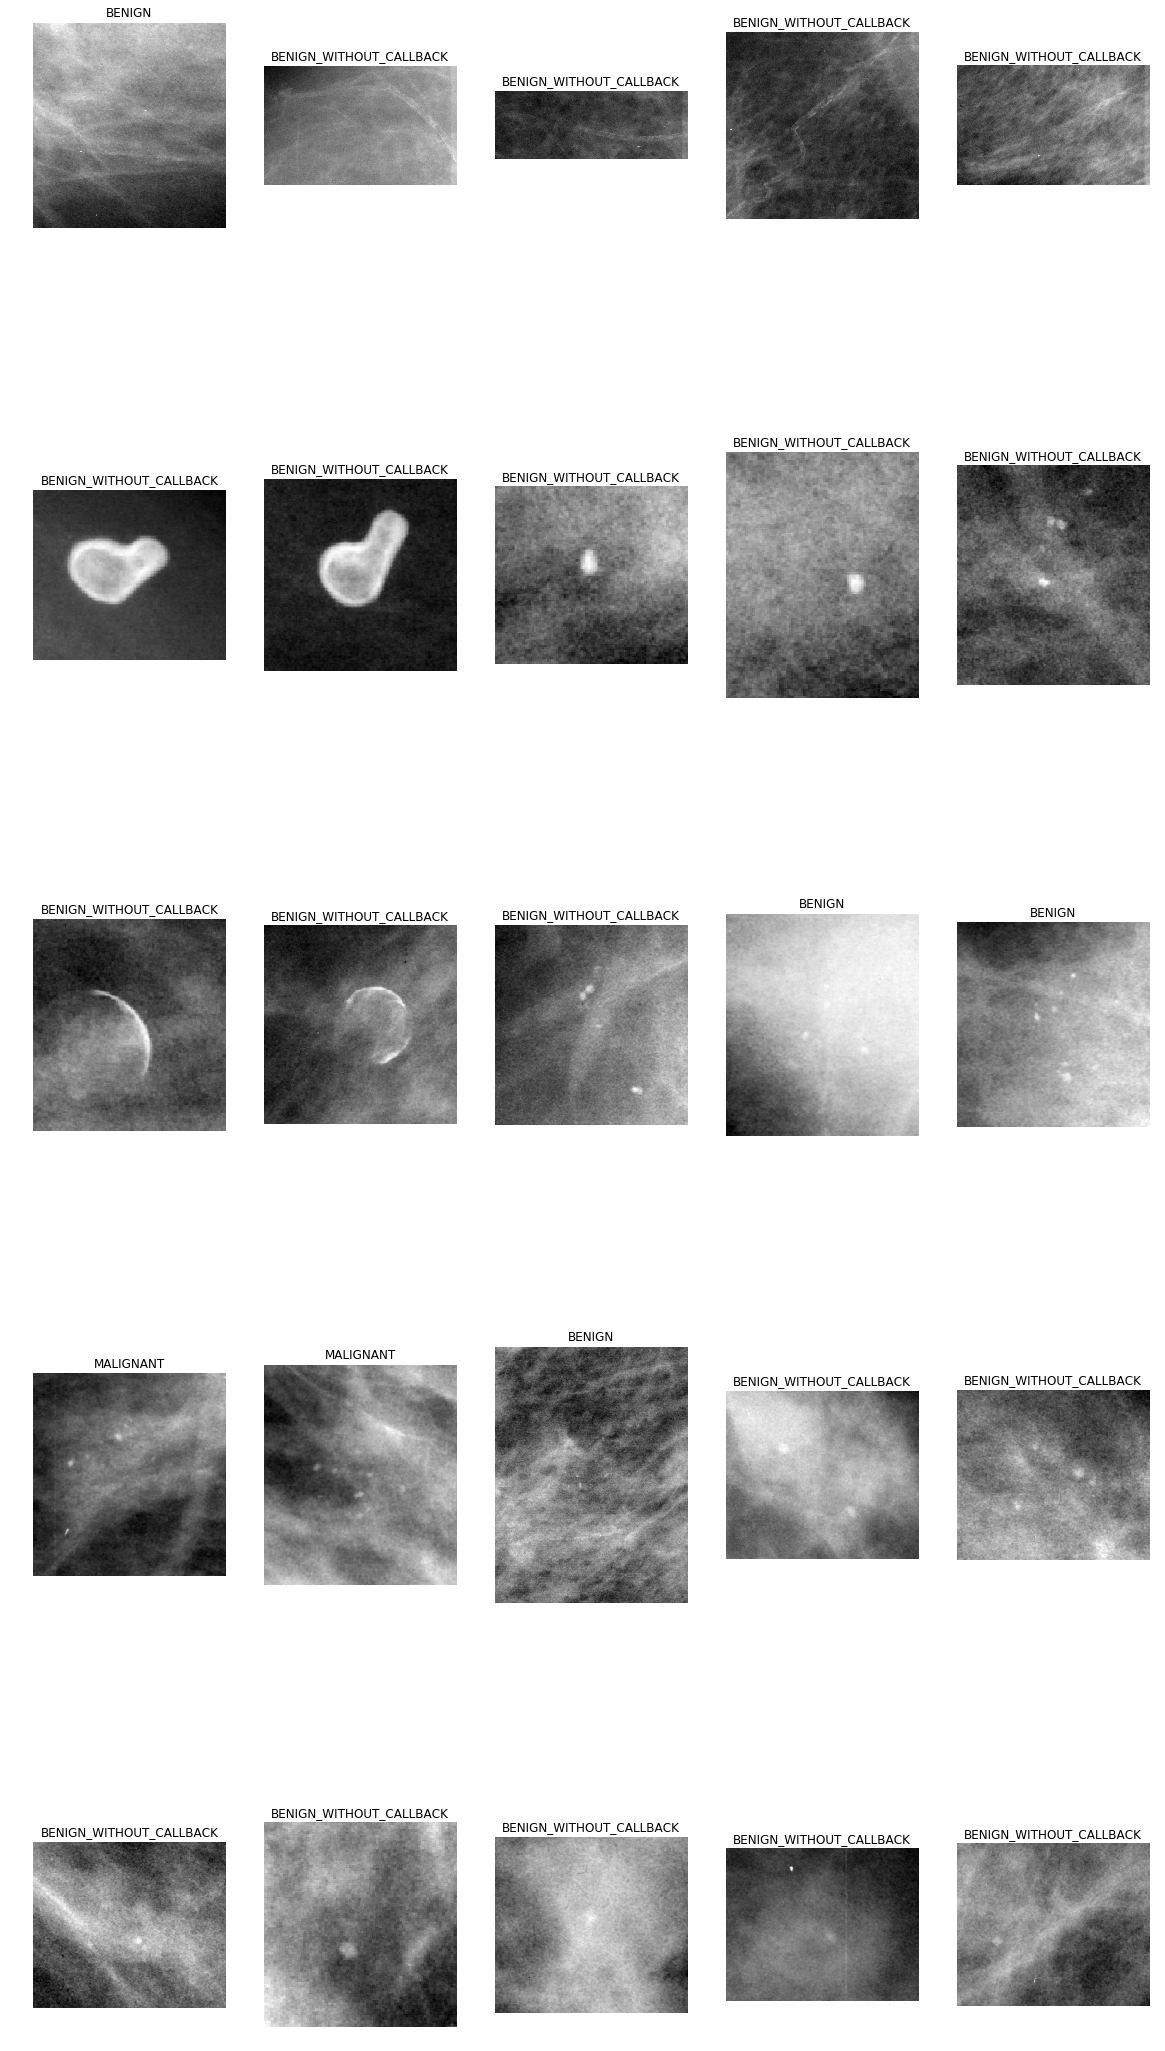

In [10]:
# plotting images of each main types

w=10
h=10
fig=plt.figure(figsize=(20, 40))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = df_test_calc['image_arrays'][i]
    fig.add_subplot(rows, columns, i)
    plt.title(df_test_calc['pathology'][i])
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
plt.show()


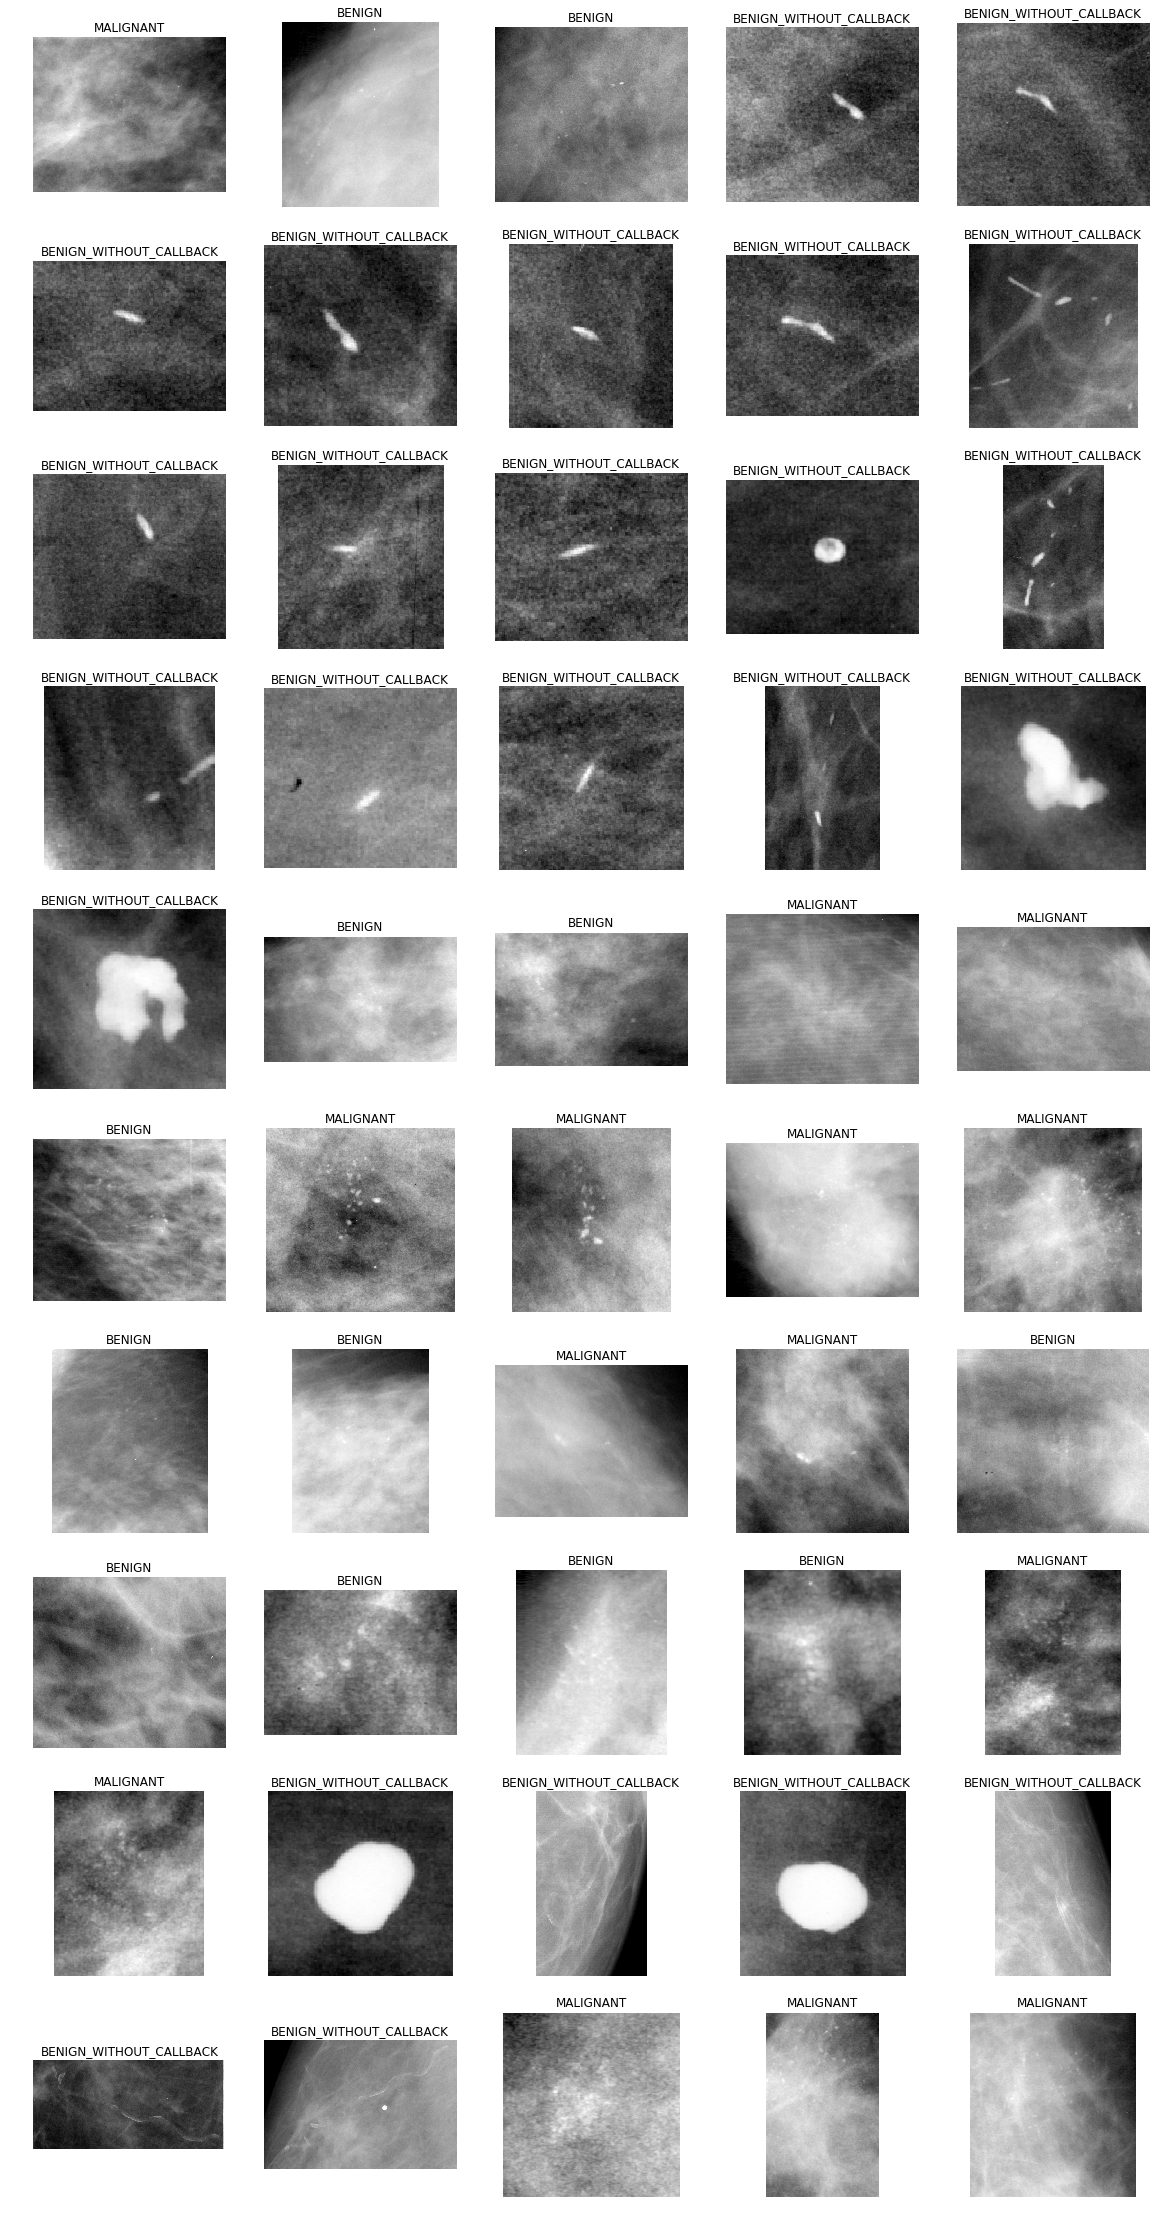

In [12]:
# plotting images of each main types

w=10
h=10
fig=plt.figure(figsize=(20, 40))
columns = 5
rows = 10
for i in range(1, columns*rows +1):
    img = df_train_calc['image_arrays'][i]
    fig.add_subplot(rows, columns, i)
    plt.title(df_train_calc['pathology'][i])
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
plt.show()

In [ ]:
# files were saved with the same names in sub folders. Here we extract the images and save them as their primary folder name
# make new excel file with new file name

def new_csv(df, new_df, file_name):

    # extract image name for new file 
    links_df = df['ROI mask file path'].str.split("/", n = 4, expand = True) 
    links_df.columns = ['image_name', 'second', 'third', 'fourth']
    df['image_name'] = links_df['image_name']
    
    # Making a new dataframe for the csv file with only id and label
    new_df = links_df[['image_name']]
    new_df['labels'] = df['pathology']
    new_df.columns = ['id', 'label']
    new_df.index = new_df['id']
    new_df.drop(columns = ['id'], inplace = True)
    
    #save to new csv file
    new_df.to_csv('./input/{}_path.csv'.format(file_name))

new_csv(df_test_calc, 'test_df', 'test_labels')
new_csv(df_train_calc, 'train_df', 'train_labels')

**Transform the images in png files**

In [12]:
df_train_calc['image_name'].head()

0     Calc-Training_P_00005_RIGHT_CC_1
1    Calc-Training_P_00005_RIGHT_MLO_1
2      Calc-Training_P_00007_LEFT_CC_1
3     Calc-Training_P_00007_LEFT_MLO_1
4      Calc-Training_P_00008_LEFT_CC_1
Name: image_name, dtype: object

In [13]:
df_train_calc['image_arrays'].head()

0    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1    [[50123, 49752, 49381, 50575, 51477, 51344, 50...
2    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3    [[35852, 36022, 35824, 35768, 35852, 35937, 36...
4    [[55766, 55485, 55099, 54783, 54044, 53938, 52...
Name: image_arrays, dtype: object

In [ ]:
# save images in new folders
def new_image_file(save_path, df):
    new_links = []
    for i in range(len(df)):
        pixel_array_numpy = df['image_arrays'][i] / 30000 

        image_path_and_name =  save_path + df['image_name'][i] + '.png'
        new_links.append(image_path_and_name)

        imageio.imwrite(image_path_and_name, pixel_array_numpy)
        
    df['new_links'] = new_links
    
new_image_file('./input/test/', df_test_calc)
new_image_file('./input/train/', df_train_calc)

In [14]:
train_labels = pd.read_csv('./input/train_labels_path.csv')
test_labels = pd.read_csv('./input/test_labels_path.csv')
train_labels['label'].value_counts()
test_labels['label'].value_counts()

BENIGN                     130
MALIGNANT                  129
BENIGN_WITHOUT_CALLBACK     67
Name: label, dtype: int64

In [21]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90.0, max_zoom=1.5, max_lighting=0.1, p_affine=0.2)
tfms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.2, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90.0, 90.0)}, p=0.2, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.5), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.2, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.45, 0.55)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.9, 1.1111111111111112)}, p=0.75, 

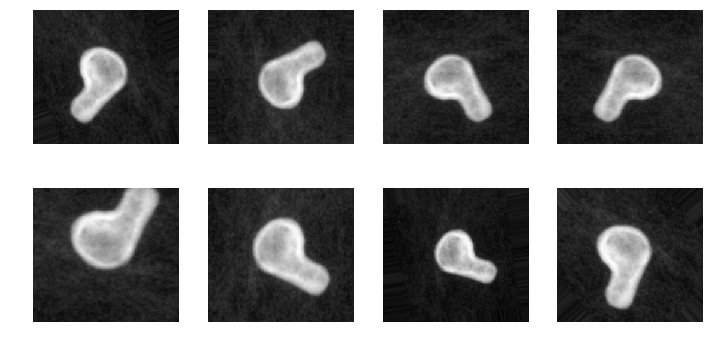

In [22]:
def get_ex(): return open_image('./input/test/Calc-Test_P_00041_LEFT_MLO_2.png')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
plots_f(2, 4, 12, 6, size=(224,244), padding_mode='border')

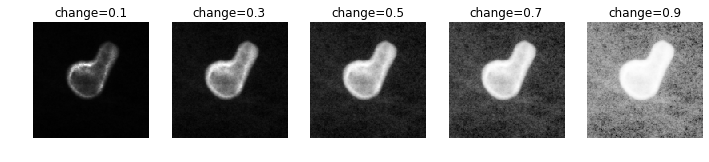

In [23]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for change, ax in zip(np.linspace(0.1,0.9,5), axs):
    brightness(get_ex(), change).show(ax=ax, title=f'change={change:.1f}')

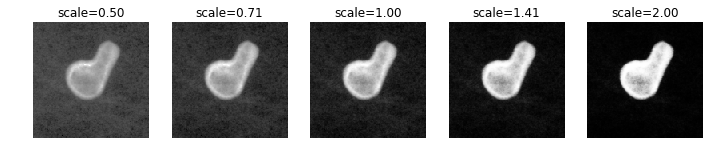

In [24]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for scale, ax in zip(np.exp(np.linspace(log(0.5),log(2),5)), axs):
    contrast(get_ex(), scale).show(ax=ax, title=f'scale={scale:.2f}')

In [15]:
# Trial 1 

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *

from fastai import *
from fastai.vision import * 
from torchvision.models import *

In [16]:
arch=resnet34

In [18]:
train_labels['label'].value_counts()


MALIGNANT                  544
BENIGN                     528
BENIGN_WITHOUT_CALLBACK    474
Name: label, dtype: int64

In [19]:
test_labels['label'].value_counts()

BENIGN                     130
MALIGNANT                  129
BENIGN_WITHOUT_CALLBACK     67
Name: label, dtype: int64

In [21]:
test_labels.columns

Index(['id', 'label'], dtype='object')

In [74]:
# Add images to Fast.ai

path = './input'

train_path = './input/train/'
test_path = './input/test/'
train_labels = './train_labels_path.csv'
test_labels = './test_labels_path.csv'



tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.2, max_zoom=0.1, max_lighting=0.1, p_affine=0.2)

np.random.seed(42)
data = ImageDataBunch.from_csv(path, csv_labels=train_labels, folder='train', valid_pct = 0.1,ds_tfms=tfms, size=300, test = 'test', suffix='.png',bs=50)

stats=data.batch_stats()        
data.normalize(stats)


ImageDataBunch;

Train: LabelList (1392 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
MALIGNANT,MALIGNANT,BENIGN,BENIGN,BENIGN_WITHOUT_CALLBACK
Path: input;

Valid: LabelList (154 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
MALIGNANT,BENIGN_WITHOUT_CALLBACK,BENIGN_WITHOUT_CALLBACK,MALIGNANT,BENIGN_WITHOUT_CALLBACK
Path: input;

Test: LabelList (322 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: EmptyLabelList
,,,,
Path: input

In [75]:
data.batch_stats()

[tensor([0.1146, 0.1146, 0.1146]), tensor([0.9824, 0.9824, 0.9824])]

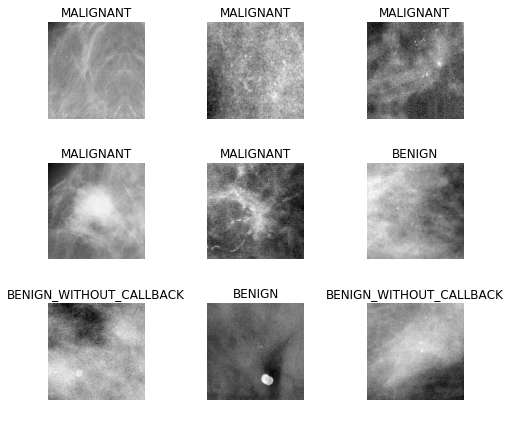

In [76]:
data.show_batch(rows = 3, figsize=(7,6))

In [77]:
print(data.classes)
len(data.classes), data.c

['BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT']


(3, 3)

In [78]:
learn = cnn_learner(data, models.densenet169, metrics = [accuracy]) #resnet50

In [79]:
learn.fit_one_cycle(1)

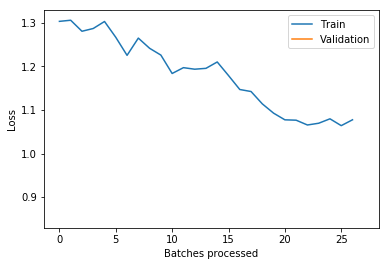

In [80]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


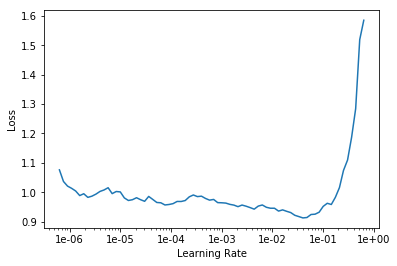

In [81]:
learn.lr_find()
learn.recorder.plot()

In [82]:

lr = 1e-3/2

learn.fit_one_cycle(10, lr) 

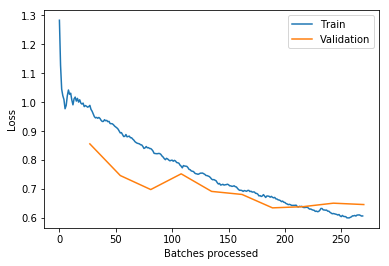

In [83]:
learn.recorder.plot_losses()

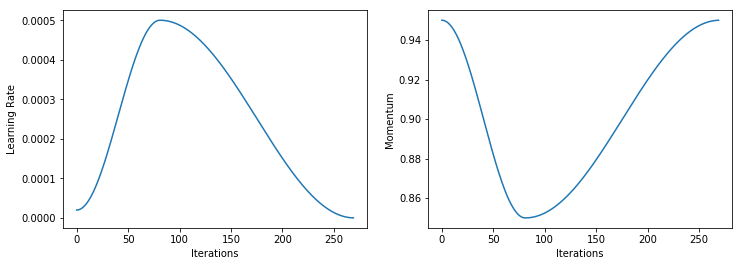

In [84]:
learn.recorder.plot_lr(show_moms=True)

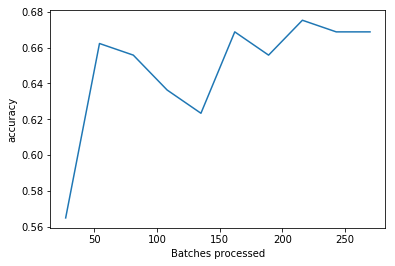

In [85]:
learn.recorder.plot_metrics()

In [86]:
interp = ClassificationInterpretation.from_learner(learn)

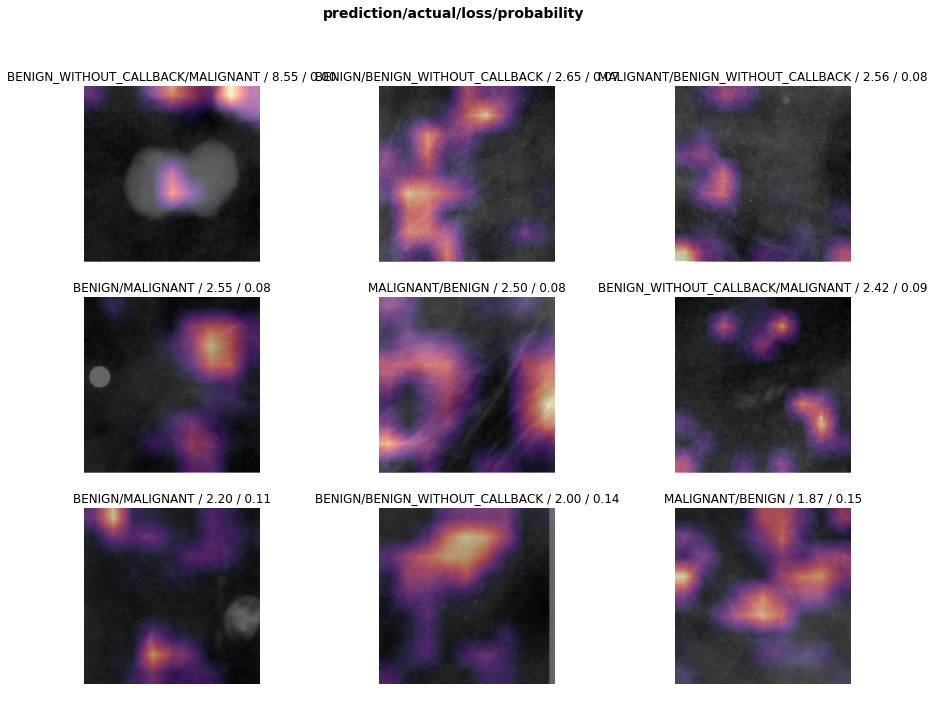

In [87]:
interp.plot_top_losses(9,figsize=(15,11))

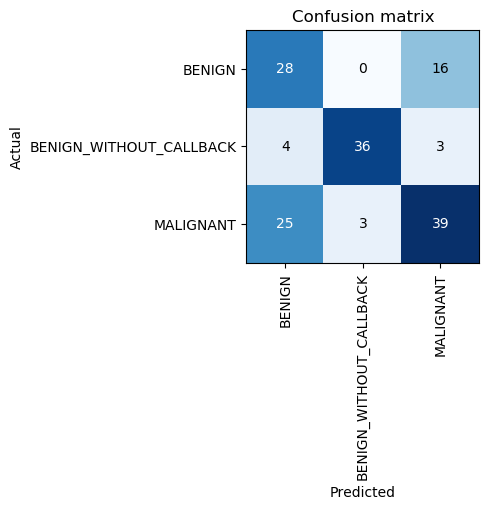

In [88]:
interp.plot_confusion_matrix(figsize=(5,5), dpi = 100)

In [89]:
interp.most_confused(min_val = 2)

[('MALIGNANT', 'BENIGN', 25),
 ('BENIGN', 'MALIGNANT', 16),
 ('BENIGN_WITHOUT_CALLBACK', 'BENIGN', 4),
 ('BENIGN_WITHOUT_CALLBACK', 'MALIGNANT', 3),
 ('MALIGNANT', 'BENIGN_WITHOUT_CALLBACK', 3)]

In [90]:
learn.save('stage_1_dn_169')

In [49]:
#fine tuning the model

In [92]:
# unfreeze the top layers and train the whole model.
learn.load('stage_1_dn_169')

learn.unfreeze()

In [93]:
# why is it worst when I unfreeze the model
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


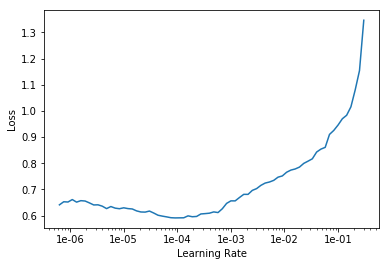

In [94]:
learn.recorder.plot()

In [97]:
learn.fit_one_cycle(10, max_lr = slice(1e-5, 1e-3/2))

#callbacks = Optional[Collection[Callback]]=None, tot_epochs =, start_epoch = 0)

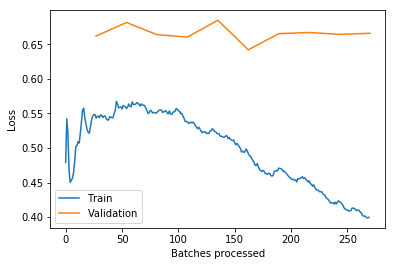

In [98]:
learn.recorder.plot_losses()

In [99]:
interp = ClassificationInterpretation.from_learner(learn)

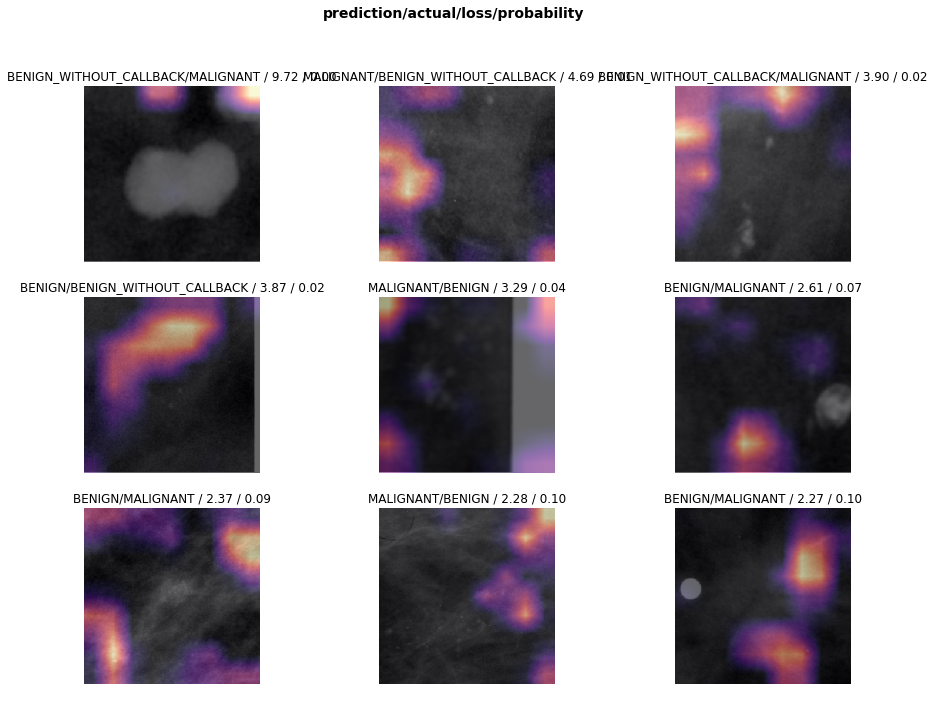

In [106]:
interp.plot_top_losses(9,figsize=(15,11))

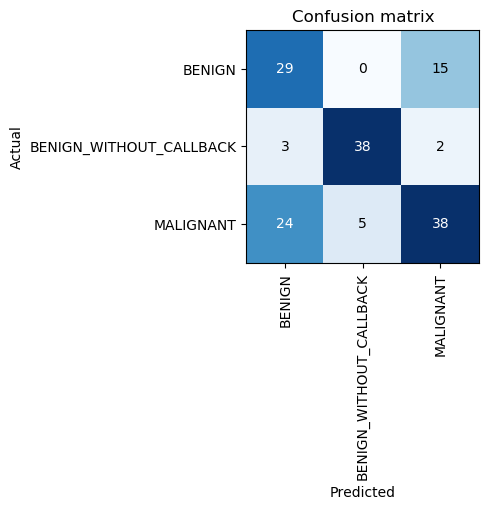

In [104]:
interp.plot_confusion_matrix(figsize=(5,5), dpi = 100)

In [105]:
interp.most_confused(min_val = 2)

[('MALIGNANT', 'BENIGN', 24),
 ('BENIGN', 'MALIGNANT', 15),
 ('MALIGNANT', 'BENIGN_WITHOUT_CALLBACK', 5),
 ('BENIGN_WITHOUT_CALLBACK', 'BENIGN', 3),
 ('BENIGN_WITHOUT_CALLBACK', 'MALIGNANT', 2)]

In [107]:
learn.save('stage-2-unfrozen-dn')

In [608]:
learn.export()

In [108]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.6818181872367859 %.


In [109]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y_pred = torch.argmax(preds, dim=1)
#learn.show_results(ds_type=DatasetType.Valid)

In [110]:
if torch.cuda.is_available():
    y_pred = y_pred.cuda()

print(y_pred, type(y_pred), y_pred.device)

y_pred = to_np(y_pred)

print(y_pred, type(y_pred))

tensor([0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 0, 0,
        2, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 1, 0,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2, 1, 0, 0,
        1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2,
        2, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2,
        1, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 0, 2, 2, 1,
        0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0,
        0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2,
        0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0,
        0, 2, 1, 1, 0, 0, 0, 2, 2, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2,
        2, 1, 0, 0, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2,
        2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0,
        2, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1,

In [111]:
y_pred

array([0, 2, 1, 0, ..., 2, 0, 2, 2])

In [112]:
file_names = []
for i in range(len(data.test_ds.x.items)):
    link = str(data.test_ds.x.items[i])
    file_names.append(link)
    
test_names = pd.DataFrame(file_names)
links_df = test_names[0].str.split("/", n = 3, expand = True) 
links_df.columns = ['input', 'test', 'image_name']
links_df['image_name'] = links_df['image_name'].str[:-4]    

In [113]:
links_df = links_df[['image_name']]
links_df['y_preds'] = y_pred
links_df = links_df.sort_values(by = ['image_name'])

In [114]:
links_df.reset_index(drop=True, inplace = True)

In [589]:
#learn.show_results(ds_type=DatasetType.Valid)

In [115]:
data.classes

['BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT']

In [118]:
test_labels = pd.read_csv('./input/test_labels_path.csv')

test_labels['label'].replace('BENIGN', 0, inplace = True)
test_labels['label'].replace('BENIGN_WITHOUT_CALLBACK', 1, inplace = True)
test_labels['label'].replace('MALIGNANT', 2, inplace = True)

In [120]:
links_df['y_true'] = test_labels['label']

In [121]:
links_df.to_csv('./input/predicted_PATH.csv')

In [122]:
y_true = links_df['y_true'].values

In [123]:
y_pred = links_df['y_preds'].values

In [124]:
# caculatate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


0.453416149068323

In [125]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[62, 10, 56],
       [21, 30, 16],
       [54, 19, 54]])

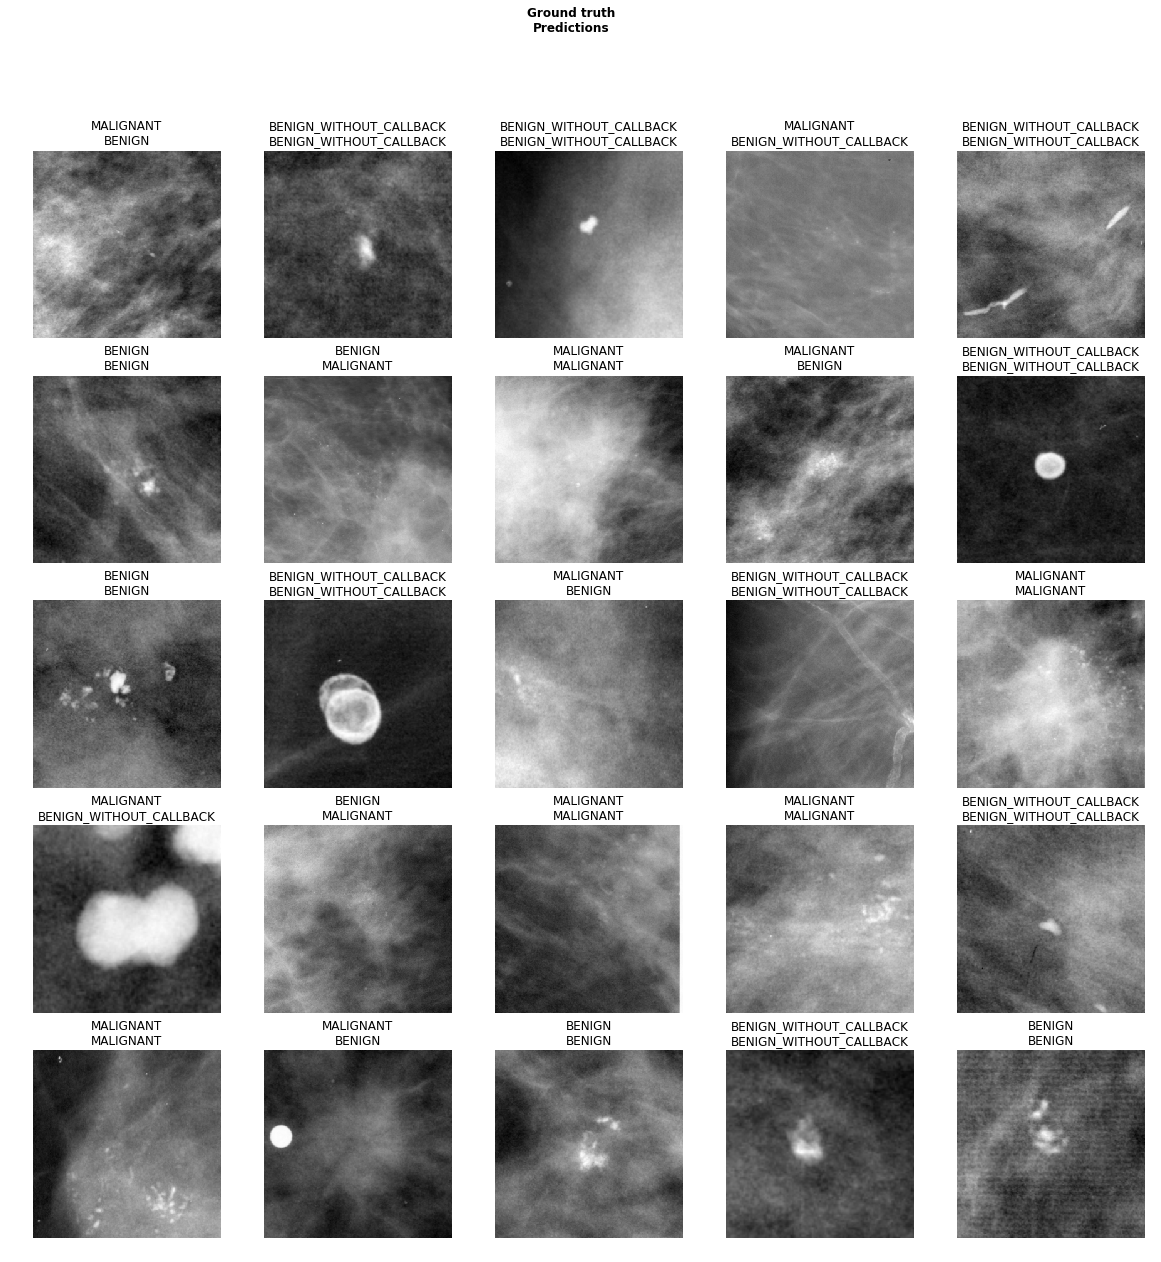

In [127]:
#preds, y, losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)
#y = torch.argmax(preds, dim=1)
learn.show_results(ds_type=DatasetType.Valid)

In [ ]:
# new image 

learn.predict(img)
